In [1]:
import matplotlib.pyplot as plt
# import simpreglib as srl
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats

plt.style.use('fivethirtyeight')

In [2]:
df1=pd.read_csv('data/cleaned_kc.csv')
df2=pd.read_csv('data/kc_house_data.csv')
dfo = df2[['price','grade','sqft_living','sqft_lot','bedrooms','bathrooms']]
df1.drop('waterfront_loc',axis=1,inplace=True)

In [ ]:
pd.plotting.scatter_matrix(dfo,figsize=(12,12))
plt.show()

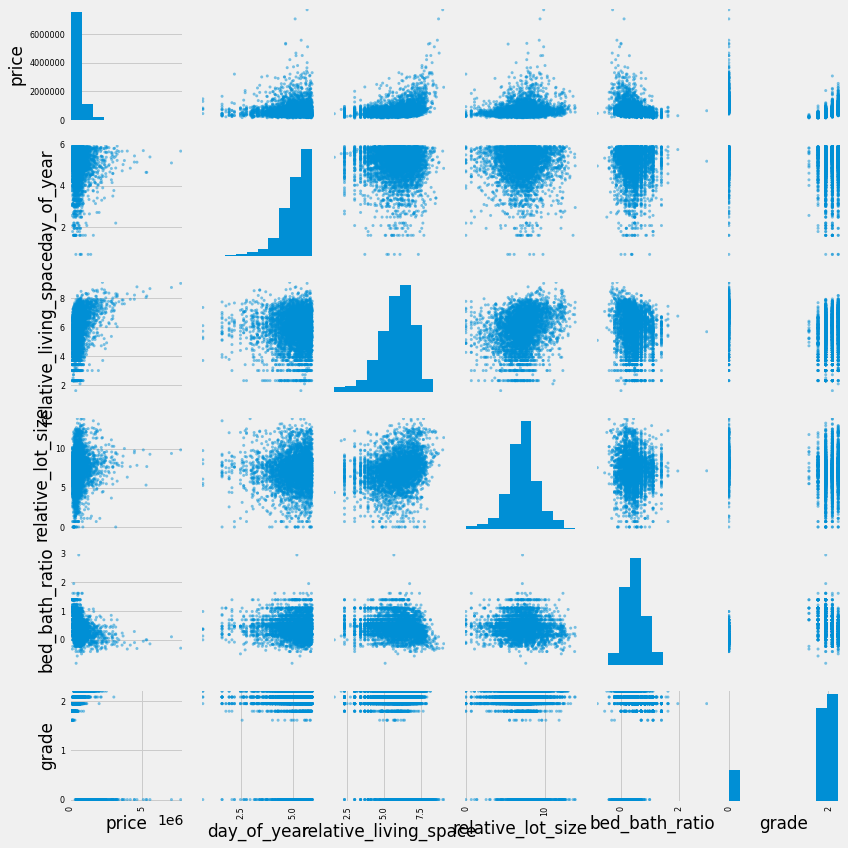

In [9]:
pd.plotting.scatter_matrix(df1,figsize=(12,12))
plt.tight_layout()
plt.show()

#### Simple linear regression on select features
Assumtion check: 
- is it linear?
- is it normal?
    - histogram
    - Q-Q plot
- is it homoscedastic?

##### For engineered features . . .

In [ ]:
# visualize the relationship between the predictors and the target using scatterplots
fig, axs = plt.subplots(1, 5,sharey=True, figsize=(18, 6))
labels = df1.columns[1:]
for idx, channel in enumerate(labels):
    df1.plot(kind='scatter', x=channel, y='price', ax=axs[idx], label=channel)
    
plt.legend()
plt.show()

In [ ]:
# # For all the variables, check distribution by creating a histogram with kde
for column in df1 :
    df1[column].plot.hist(density=True,label = column+' histogram')
    df1[column].plot.kde(label = column+' kde')
    plt.legend()
    plt.show()

In [3]:
outcome = 'price'
x_cols =  ['day_of_year', 'relative_living_space', 'relative_lot_size','bed_bath_ratio', 'grade']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     1702.
Date:                Mon, 07 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:45:09   Log-Likelihood:            -3.0380e+05
No. Observations:               21597   AIC:                         6.076e+05
Df Residuals:                   21591   BIC:                         6.077e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               1.11e+06   1.08e+04    102.665      0.000    1.09e+06    1.13e+06
day_of_year             -70.0834     22.354     -3.135      0.002    -113.900     -26.267
relative_living_space   203.4459      3.615     56.282      0.000     196.361     210.531
relative_lot_size         0.1045      0.073      1.423      0.155      -0.039       0.249
bed_bath_ratio        -1.082e+05   3228.621    -33.523      0.000   -1.15e+05   -1.02e+05
grade                 -5.567e+04   1122.844    -49.581      0.000   -5.79e+04   -5.35e+04
==============================================================================
Omnibus:                    14649.891   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           416292.258
Skew:                           2.868   Prob(JB):                         0.00
Kurtosis:                      23.729   Cond. No.                     1.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

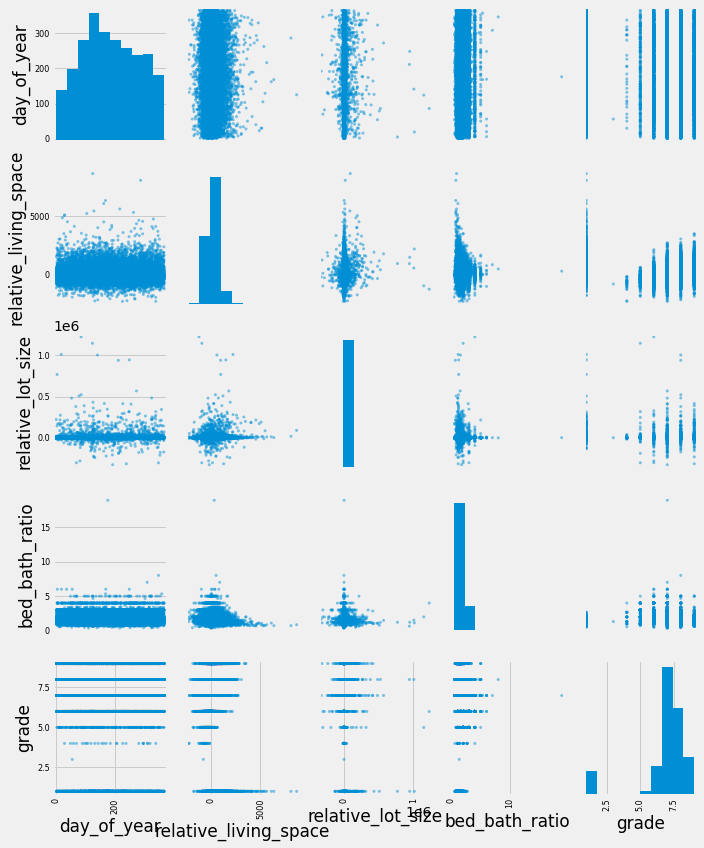

In [9]:
pd.plotting.scatter_matrix(df1[x_cols], figsize=(10,12));
plt.tight_layout()
plt.show()

The plots above show relative living space, and grade to be the most promising

In [4]:
non_normal = list(df1.columns[1:])

# log transform data frame
for feat in non_normal: 
    df1[feat] = df1[feat].map(lambda x: np.log(x))
    df1.loc[df1[feat].isnull()] = 0

 # deal with valuable zeros
for feat in ['relative_living_space','relative_lot_size']:
    df1[feat] = df1[feat].fillna(0)

 # deal with -inf values
for label in df1.columns: # deal with -inf values
    df1.drop(df1.index[df1[label] == np.NINF], inplace=True)


<ipython-input-4-4bd97a7b3af6>:5: RuntimeWarning: invalid value encountered in log
  df1[feat] = df1[feat].map(lambda x: np.log(x))
<ipython-input-4-4bd97a7b3af6>:5: RuntimeWarning: divide by zero encountered in log
  df1[feat] = df1[feat].map(lambda x: np.log(x))


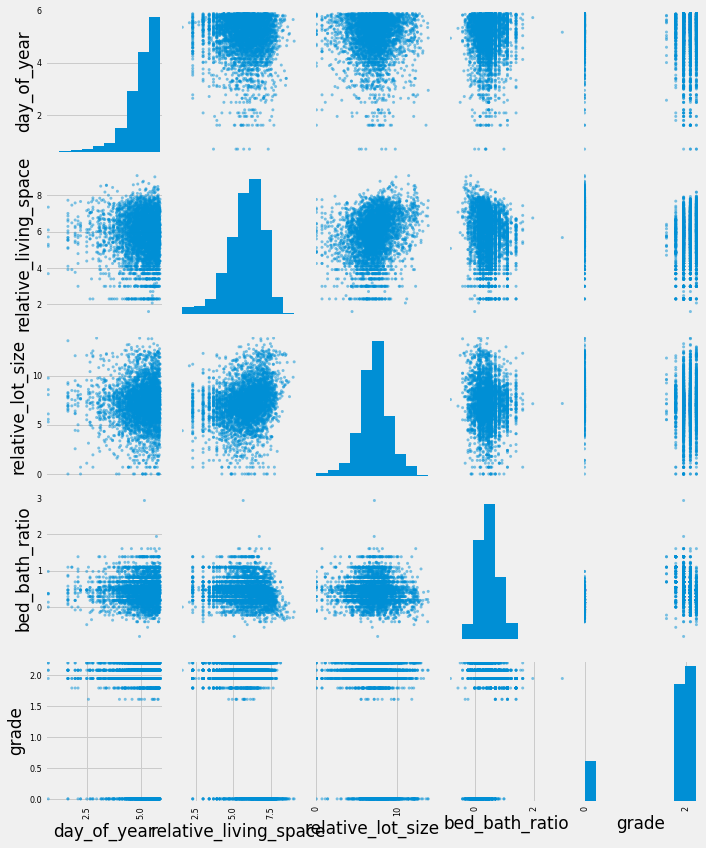

In [11]:
pd.plotting.scatter_matrix(df1[x_cols], figsize=(10,12));
plt.tight_layout()
plt.show()

In [5]:
outcome = 'price'
x_cols =  ['day_of_year', 'relative_living_space', 'relative_lot_size','bed_bath_ratio', 'grade']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     554.8
Date:                Mon, 07 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:45:31   Log-Likelihood:                -61528.
No. Observations:                4304   AIC:                         1.231e+05
Df Residuals:                    4298   BIC:                         1.231e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              7.287e+05   5.78e+04     12.602      0.000    6.15e+05    8.42e+05
day_of_year            4294.2528   7885.990      0.545      0.586   -1.12e+04    1.98e+04
relative_living_space  9.823e+04   5293.186     18.557      0.000    8.78e+04    1.09e+05
relative_lot_size      2689.4888   3085.837      0.872      0.383   -3360.344    8739.322
bed_bath_ratio         -2.89e+05    1.9e+04    -15.176      0.000   -3.26e+05   -2.52e+05
grade                 -3.151e+05   8940.339    -35.249      0.000   -3.33e+05   -2.98e+05
==============================================================================
Omnibus:                     3700.830   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           224557.912
Skew:                           3.772   Prob(JB):                         0.00
Kurtosis:                      37.573   Cond. No.                         106.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# fspace = 'price~relative_living_space'
# fsize = 'price~relative_lot_size'
# fgrade = 'price~grade'
# fday = 'price~day_of_year'
# fbb = 'price~bed_bath_ratio'

# space_model = smf.ols(formula=fspace, data=df1).fit()
# size_model = smf.ols(formula=fsize, data=df1).fit()
# grade_model = smf.ols(formula=fgrade, data=df1).fit()
# day_model = smf.ols(formula=fday, data=df1).fit()
# fbb_model = smf.ols(formula=fbb, data=df1).fit()

In [6]:
# print(space_model.pvalues)
# space_model.summary()